In [3]:
import numpy as np
import pandas as pd
from typing import Mapping, List, Tuple
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
    load_breast_cancer, load_diabetes, fetch_mldata
from  matplotlib.collections import LineCollection
import time
from pandas.api.types import is_string_dtype, is_object_dtype, is_categorical_dtype, is_bool_dtype
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from pdpbox import pdp
from rfpimp import *
from scipy.integrate import cumtrapz
from stratx.partdep import *
from stratx.ice import *

%config InlineBackend.figure_formats = ['svg','png']

from stratx.support import *

In [2]:
X, y = load_rent(n=10_000)

Rent has 49352 records


In [5]:
np.unique(X['bathrooms'], return_counts=True)

(array([0. , 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. ]),
 array([  54, 8151,  140, 1539,   39,   67,    3,    7]))

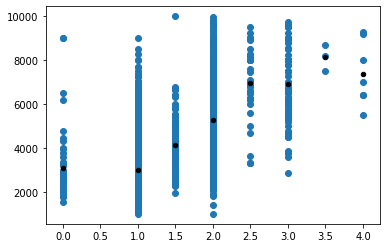

In [15]:
plt.scatter(X['bathrooms'],y)
df = pd.concat([X,y], axis=1)
avg_per_baths = df.groupby('bathrooms').mean()['price']
plt.scatter(np.unique(X['bathrooms']), avg_per_baths, s=20, c='black')
plt.show()

In [19]:
X, y = load_bulldozer(n=10_000)
df = pd.concat([X,y], axis=1)

Loading cached version...


In [20]:
df.describe()

,ModelID,datasource,YearMade,auctioneerID,MachineHours,age,AC,ProductSize,MachineHours_na,saleyear,salemonth,saleday,saledayofweek,saledayofyear,SalePrice
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8711.008800,145.850300,1999.714000,7.250700,4519.155500,10.940000,0.384800,1.416000,0.494500,2010.654000,7.150000,16.970000,2.383600,203.211500,33497.800000
std,7699.220095,15.349249,7.419805,20.718532,9041.231818,7.437092,0.486572,1.696653,0.499995,0.475717,3.263857,8.450553,1.204739,98.314261,24938.753758
min,28.000000,121.000000,1953.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,2010.000000,1.000000,1.000000,0.000000,6.000000,4750.000000
25%,3282.000000,132.000000,1997.000000,1.000000,3138.000000,6.000000,0.000000,0.000000,0.000000,2010.000000,5.000000,10.000000,1.000000,131.000000,15000.000000
50%,4701.000000,149.000000,2002.000000,1.000000,3138.000000,9.000000,0.000000,0.000000,0.000000,2011.000000,7.000000,17.000000,2.000000,207.000000,25000.000000
75%,14287.250000,149.000000,2005.000000,3.000000,4330.000000,14.000000,1.000000,3.000000,1.000000,2011.000000,10.000000,25.000000,3.000000,280.000000,45000.000000
max,36877.000000,172.000000,2011.000000,99.000000,821747.000000,58.000000,1.000000,5.000000,1.000000,2011.000000,12.000000,31.000000,6.000000,364.000000,142000.000000


In [23]:
np.mean(X[X['MachineHours_na']==0]['YearMade']), np.mean(X[X['MachineHours_na']==1]['YearMade'])

(2000.8344213649852, 1998.56865520728)

In [22]:
np.mean(df[X['MachineHours_na']==0]['SalePrice']), np.mean(df[X['MachineHours_na']==1]['SalePrice'])

(35628.03165182987, 31320.182002022244)

In [13]:
X['YearMade'].mean()

1999.5962

In [25]:
sum(X['MachineHours_na']==1), len(X)

(4945, 10000)

In [17]:
X[X['MachineHours_na']==0].describe()

,ModelID,datasource,YearMade,auctioneerID,MachineHours,age,AC,ProductSize,MachineHours_na,saleyear,salemonth,saleday,saledayofweek,saledayofyear
count,5102.000000,5102.000000,5102.000000,5102.000000,5102.000000,5102.000000,5102.000000,5102.000000,5102.0,5102.000000,5102.000000,5102.000000,5102.000000,5102.000000
mean,9159.409055,148.208742,2000.789494,5.641513,5727.458840,9.840651,0.451392,1.526656,0.0,2010.630145,7.182869,16.785770,2.355743,204.019600
std,7922.000286,19.137298,6.105039,18.146085,5154.115279,6.135653,0.497680,1.717666,0.0,0.482813,3.290675,8.319686,1.175897,98.986881
min,28.000000,121.000000,1965.000000,0.000000,4.000000,1.000000,0.000000,0.000000,0.0,2010.000000,1.000000,1.000000,0.000000,6.000000
25%,3269.000000,132.000000,1998.000000,1.000000,2223.250000,6.000000,0.000000,0.000000,0.0,2010.000000,4.000000,10.000000,1.000000,119.000000
50%,4764.000000,149.000000,2003.000000,1.000000,4291.000000,8.000000,0.000000,1.000000,0.0,2011.000000,7.000000,16.000000,3.000000,208.000000
75%,14380.750000,172.000000,2005.000000,3.000000,7758.750000,13.000000,1.000000,3.000000,0.0,2011.000000,10.000000,24.000000,3.000000,287.000000
max,36879.000000,172.000000,2010.000000,99.000000,94075.000000,45.000000,1.000000,5.000000,0.0,2011.000000,12.000000,31.000000,6.000000,363.000000


In [16]:
X[X['MachineHours_na']==1].describe()

,ModelID,datasource,YearMade,auctioneerID,MachineHours,age,AC,ProductSize,MachineHours_na,saleyear,salemonth,saleday,saledayofweek,saledayofyear
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.0,4898.000000,4898.000000,4898.000000,4898.0,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,8178.573295,143.825847,1998.353205,8.352797,3138.0,12.316864,0.316252,1.339526,1.0,2010.670069,7.213148,16.964884,2.434871,205.167619
std,7335.043853,10.171517,8.752175,22.335690,0.0,8.741988,0.465060,1.683950,0.0,0.470236,3.244621,8.619494,1.249196,97.849759
min,28.000000,121.000000,1960.000000,0.000000,3138.0,0.000000,0.000000,0.000000,1.0,2010.000000,1.000000,1.000000,0.000000,12.000000
25%,3356.000000,132.000000,1995.000000,1.000000,3138.0,6.000000,0.000000,0.000000,1.0,2010.000000,5.000000,9.000000,2.000000,145.000000
50%,4640.000000,149.000000,2001.000000,1.000000,3138.0,10.000000,0.000000,0.000000,1.0,2011.000000,7.000000,17.000000,2.000000,208.000000
75%,13247.000000,149.000000,2005.000000,3.000000,3138.0,15.000000,1.000000,3.000000,1.0,2011.000000,10.000000,25.000000,3.000000,279.000000
max,36847.000000,172.000000,2011.000000,99.000000,3138.0,51.000000,1.000000,5.000000,1.0,2011.000000,12.000000,31.000000,6.000000,364.000000
